# Character-Level Language Model for Name Generation

This notebook implements a character-level language model using a custom neural network architecture to generate names. The model learns to predict the next character in a sequence given a context of previous characters.

## Overview

- **Task**: Generate names character by character
- **Architecture**: Custom neural network with embedding, linear layers, batch normalization, and tanh activations
- **Training**: Stochastic gradient descent with learning rate decay
- **Tracking**: MLflow and Weights & Biases (wandb) for experiment tracking


## 1. Installation and Setup

Install required packages for experiment tracking.


In [1]:
# !pip install mlflow

## 2. Import Libraries and Configure Device

Import PyTorch and other necessary libraries. Configure the device to use CUDA if available, otherwise fall back to CPU.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 3. Data Preprocessing

Load and clean the dataset by removing special characters that were inserted into the names.


### Split Dataset

Split the dataset into training (80%), validation (10%), and test (10%) sets.


In [ ]:
import re


def remove_special_chars_from_file(filepath='../data/synthetic_data.txt'):
    """
    Loads names from a specified file path and uses Regular Expressions
    to remove all previously inserted special characters.

    Args:
        filepath (str): The full path to the file containing the modified names.

    Returns:
        list: A list of the cleaned names.
    """

    # Define the RegEx Pattern to remove the special characters:
    # ['%', '1', '2', '_', '@', '3', '0', '#', '$', '!', '&']
    pattern_to_remove = r'[%12_@30#$!&]'

    cleaned_names = []

    try:
        # --- 1. Load the words using your specified method ---
        words = open(filepath, 'r').read().splitlines()

        print(f"Total words loaded from '{filepath}': {len(words)}")
        print(f"Length of longest word: {max(len(w) for w in words)}")
        print(f"First 10 words (modified): {words[:10]}\n")

        # --- 2. Process each word/name using re.sub() ---
        for modified_name in words:

            # re.sub(pattern, replacement, string)
            # Replaces any match of the pattern with an empty string ('')
            clean_name = re.sub(pattern_to_remove, '', modified_name)

            cleaned_names.append(clean_name)

    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return []
    except ValueError as e:
        print(
            f"Error processing word lengths (file might be empty or contain non-text data): {e}")
        return []

    return cleaned_names

# -----------------------
# EXECUTION
# -----------------------


# Run the function with the custom file path
words = remove_special_chars_from_file()

# Print the results
if words:
    print("\n--- Example Cleaned Names (First 20) ---")
    for name in words[:20]:
        print(name)

    # Optional: Save the cleaned data back to a new file
    # with open("cleaned_data.txt", "w") as outfile:
    #     outfile.write('\n'.join(words))
    # print("\nCleaned results saved to 'cleaned_data.txt'")

print("The First 20 words are", words[:20])

Total words loaded from '../data/synthetic_data.txt': 32033
Length of longest word: 16
First 10 words (modified): ['e$mma', 'o1livia', 'a#va', 'is@abella', 'soph&ia', 'charlot2te', 'mia!', 'amel0ia', 'harper$', 'eve3lyn']


--- Example Cleaned Names (First 20) ---
emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'wil

## 8. Experiment Tracking Setup

Configure MLflow and Weights & Biases for tracking experiments, metrics, and model parameters.


### Visualize Sample Data

Display examples of context-target pairs to understand the data format.


### Weights & Biases Setup

Initialize W&B for experiment tracking and visualization.


## 4. Build Vocabulary

Create character-to-integer and integer-to-character mappings. The vocabulary includes all lowercase letters (a-z) and a special '.' token (index 0) to mark the end of a name.


## 9. Model Initialization

Set random seeds for reproducibility and initialize the neural network model.


## 7. Custom Neural Network Layers

Implement custom neural network layers from scratch (without using PyTorch's built-in layers) to understand the underlying mechanics.


## 5. Shuffle Dataset

Randomly shuffle the words to ensure the training, validation, and test sets are representative. Using a fixed seed (42) for reproducibility.


### Test Model Forward Pass

Verify the model architecture by running a forward pass and checking tensor shapes.


### Inspect Layer Output Shapes

Check the shape of activations at each layer to understand data flow through the network.


### Learning Rate Schedule

The training uses a learning rate decay strategy:

- **Steps 0-150,000**: Learning rate = 0.1 (faster initial learning)
- **Steps 150,000-200,000**: Learning rate = 0.01 (slower fine-tuning)

This helps the model learn quickly initially, then refine its predictions more carefully.


In [4]:
# Build the vocabulary of characters and mapping to/from integers
# The vocabulary consists of all unique characters found in the dataset

# Extract all unique characters from all words and sort them alphabetically
chars = sorted(list(set(''.join(words))))

# Create string-to-integer mapping (stoi)
# Assign indices 1-26 to letters a-z
stoi = {s: i+1 for i, s in enumerate(chars)}
# Special token: '.' (end-of-word marker) gets index 0
stoi['.'] = 0

# Create integer-to-string mapping (itos) - inverse of stoi
itos = {i: s for s, i in stoi.items()}

# Vocabulary size: number of unique characters + 1 (for the '.' token)
vocab_size = len(itos)

print("Character to index mapping:", itos)
print(f"Vocabulary size: {vocab_size}")

Character to index mapping: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocabulary size: 27


### Visualize Training Loss

Plot the training loss over time. The loss is averaged over 1000-step windows to smooth out noise.


## 11. Model Evaluation

Switch model to evaluation mode and compute loss on training and validation sets.


## 12. Generate Names

Sample new names from the trained model. The model generates names character by character, stopping when it predicts the end-of-word token ('.').


## 10. Training Loop

Train the model using stochastic gradient descent with learning rate decay. The model learns to predict the next character given a context of previous characters.


## 6. Build Training Dataset

Convert words into sequences of character contexts and targets. Each example consists of a context window (previous characters) and a target (next character to predict).


In [5]:
# Shuffle the words to randomize the dataset order
# This ensures that training, validation, and test sets are representative
# and not biased by the original ordering of the data
import random

# Set random seed for reproducibility
random.seed(42)

# Shuffle the words in-place
random.shuffle(words)

In [6]:
# Build the training dataset
# block_size: context window size (number of previous characters to consider)
block_size = 8


def build_dataset(words):
    """
    Build training dataset from a list of words.

    For each word, creates sequences where each position predicts the next character.
    The context window slides through the word, and each character becomes a target.
    A special '.' token is appended to mark the end of each word.

    Args:
        words (list): List of words (strings) to convert into training examples.

    Returns:
        tuple: (X, Y) where:
            - X: Tensor of shape (N, block_size) containing context windows
            - Y: Tensor of shape (N,) containing target character indices
            Both tensors are moved to the configured device (CPU/GPU).

    Example:
        For word "cat" with block_size=3:
        - Context: [0,0,0] -> Target: 'c'
        - Context: [0,0,c] -> Target: 'a'
        - Context: [0,c,a] -> Target: 't'
        - Context: [c,a,t] -> Target: '.'
    """
    X, Y = [], []  # Input contexts and target characters

    for w in words:
        # Initialize context with padding (0 = '.' token)
        context = [0] * block_size

        # Process each character in the word, plus the end token
        for ch in w + '.':
            # Convert character to integer index
            ix = stoi[ch]

            # Add current context and target to dataset
            X.append(context)
            Y.append(ix)

            # Shift context window: remove first element, add current character
            context = context[1:] + [ix]

    # Convert to PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Dataset shape - X: {X.shape}, Y: {Y.shape}")

    # Move tensors to device (GPU if available)
    return X.to(device), Y.to(device)


# Split dataset into train (80%), validation (10%), and test (10%)
n1 = int(0.8 * len(words))  # 80% split point
n2 = int(0.9 * len(words))  # 90% split point

# Build datasets for each split
Xtr, Ytr = build_dataset(words[:n1])      # Training set: first 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # Validation set: 80-90%
Xte, Yte = build_dataset(words[n2:])      # Test set: last 10%

Dataset shape - X: torch.Size([182625, 8]), Y: torch.Size([182625])
Dataset shape - X: torch.Size([22655, 8]), Y: torch.Size([22655])
Dataset shape - X: torch.Size([22866, 8]), Y: torch.Size([22866])


In [7]:
# Display examples of context-target pairs from the training set
# This helps visualize how the data is structured: context window -> target character
for x, y in zip(Xtr[:20], Ytr[:20]):
    # Convert context indices to characters and display with target
    context_str = ''.join(itos[ix.item()] for ix in x)
    target_char = itos[y.item()]
    print(f"{context_str} -----> {target_char}")

........ -----> y
.......y -----> u
......yu -----> h
.....yuh -----> e
....yuhe -----> n
...yuhen -----> g
..yuheng -----> .
........ -----> d
.......d -----> i
......di -----> o
.....dio -----> n
....dion -----> d
...diond -----> r
..diondr -----> e
.diondre -----> .
........ -----> x
.......x -----> a
......xa -----> v
.....xav -----> i
....xavi -----> e


In [ ]:
# Copy from the part 3

# ----------------------------------------------

class Linear:
    """
    Fully connected (linear) layer implementation.

    Performs the operation: output = input @ weight + bias
    Weights are initialized using Kaiming initialization (scaled by 1/sqrt(fan_in))
    to help with gradient flow in deep networks.

    Args:
        fan_in (int): Number of input features (input dimension)
        fan_out (int): Number of output features (output dimension)
        bias (bool): Whether to include a bias term. Default: True
    """

    def __init__(self, fan_in, fan_out, bias=True) -> None:
        # Initialize weights with Kaiming initialization (scaled by 1/sqrt(fan_in))
        # This helps maintain variance of activations across layers
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # Initialize bias to zero
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        """
        Forward pass through the linear layer.

        Args:
            x: Input tensor of shape (..., fan_in)

        Returns:
            Output tensor of shape (..., fan_out)
        """
        # Matrix multiplication: x @ weight
        self.out = x @ self.weight
        # Add bias if present
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        """
        Return list of trainable parameters for gradient computation.

        Returns:
            list: List containing weight tensor and bias tensor (if present)
        """
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ----------------------------------------------


class BatchNormld:
    """
    Batch Normalization layer implementation.

    Normalizes inputs to have zero mean and unit variance, then applies
    learnable scale (gamma) and shift (beta) parameters. This helps with:
    - Faster training convergence
    - More stable gradients
    - Reduced sensitivity to initialization

    During training: uses batch statistics
    During inference: uses running statistics accumulated during training

    Args:
        dim (int): Number of features/channels to normalize
        eps (float): Small constant added to variance to prevent division by zero. Default: 1e-5
        momentum (float): Momentum for updating running statistics. Default: 0.1
    """

    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps  # Epsilon for numerical stability
        self.momentum = momentum  # Momentum for running statistics update
        self.training = True  # Training mode flag

        # Learnable parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)  # Scale parameter (initialized to 1)
        self.beta = torch.zeros(dim)  # Shift parameter (initialized to 0)

        # Running statistics (updated with momentum during training)
        self.running_mean = torch.zeros(dim)  # Running mean
        self.running_var = torch.ones(dim)    # Running variance

    def __call__(self, x):
        """
        Forward pass through batch normalization.

        Args:
            x: Input tensor of shape (batch, ...) or (batch, time, features)

        Returns:
            Normalized and scaled output tensor
        """
        # Calculate statistics based on mode
        if self.training:
            # During training: compute statistics from current batch
            if x.ndim == 2:
                dim = 0  # Normalize over batch dimension for 2D tensors
            elif x.ndim == 3:
                dim = (0, 1)  # Normalize over batch and time for 3D tensors

            xmean = x.mean(dim, keepdim=True)  # Batch mean
            xvar = x.var(dim, keepdim=True)    # Batch variance
        else:
            # During inference: use accumulated running statistics
            xmean = self.running_mean
            xvar = self.running_var

        # Normalize: (x - mean) / sqrt(variance + eps)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Apply learnable scale and shift: gamma * xhat + beta
        self.out = self.gamma * xhat + self.beta

        # Update running statistics during training
        if self.training:
            with torch.no_grad():
                # Exponential moving average of mean and variance
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        """
        Return list of learnable parameters (gamma and beta).

        Returns:
            list: [gamma, beta] tensors
        """
        return [self.gamma, self.beta]

# ----------------------------------------------


class Tanh:
    """
    Hyperbolic tangent activation function.

    Applies tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
    Outputs values in the range (-1, 1).

    This activation function helps introduce non-linearity into the network,
    allowing it to learn complex patterns. Tanh is zero-centered, which can
    help with gradient flow compared to sigmoid.
    """

    def __call__(self, x):
        """
        Forward pass through tanh activation.

        Args:
            x: Input tensor of any shape

        Returns:
            Output tensor with same shape, values in (-1, 1)
        """
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        """
        Return empty list (no learnable parameters).

        Returns:
            list: Empty list
        """
        return []

# ----------------------------------------------


class Embedding:
    """
    Embedding layer that maps integer indices to dense vector representations.

    This layer converts discrete character indices into continuous vector
    representations that can be learned during training. Each character gets
    a unique embedding vector that captures its semantic properties.

    Args:
        num_embeddings (int): Size of the vocabulary (number of unique characters)
        embedding_dim (int): Dimension of the embedding vectors
    """

    def __init__(self, num_embeddings, embedding_dim) -> None:
        # Initialize embedding weights randomly
        # Shape: (vocab_size, embedding_dim)
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        """
        Forward pass: look up embeddings for given indices.

        Args:
            IX: Tensor of integer indices of shape (...,)
                Each index should be in range [0, num_embeddings)

        Returns:
            Embedding vectors of shape (..., embedding_dim)
        """
        # Index into the weight matrix to get embeddings
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        """
        Return list of learnable parameters.

        Returns:
            list: [weight] tensor containing embedding matrix
        """
        return [self.weight]

    # ----------------------------------------------


class FlattenConsecutive:
    """
    Flatten consecutive time steps together to increase receptive field.

    This layer groups consecutive time steps and concatenates their features.
    For example, with n=2, it groups pairs of consecutive time steps.
    This effectively increases the context window that subsequent layers can see.

    Args:
        n (int): Number of consecutive time steps to group together
    """

    def __init__(self, n):
        self.n = n  # Number of consecutive steps to flatten

    def __call__(self, x):
        """
        Forward pass: flatten consecutive time steps.

        Args:
            x: Input tensor of shape (batch, time, features)

        Returns:
            Output tensor of shape:
            - (batch, time//n, features*n) if time//n > 1
            - (batch, features*n) if time//n == 1 (squeezed)
        """
        B, T, C = x.shape  # Batch, Time, Channels/Features

        # Reshape to group n consecutive time steps
        # New shape: (batch, time//n, features*n)
        x = x.view(B, T//self.n, C*self.n)

        # If only one time step remains, remove that dimension
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out

    def parameters(self):
        """
        Return empty list (no learnable parameters).

        Returns:
            list: Empty list
        """
        return []
    # ----------------------------------------------


class Sequential:
    """
    Container that applies a sequence of layers in order.

    Similar to PyTorch's nn.Sequential, this class chains multiple layers
    together so that the output of one layer becomes the input of the next.

    Args:
        layers (list): List of layer objects to apply sequentially
    """

    def __init__(self, layers) -> None:
        self.layers = layers  # Store list of layers

    def __call__(self, x):
        """
        Forward pass through all layers sequentially.

        Args:
            x: Input tensor

        Returns:
            Output tensor after passing through all layers
        """
        # Apply each layer in sequence
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        """
        Collect all parameters from all layers.

        Returns:
            list: Flattened list of all parameter tensors from all layers
        """
        return [p for layer in self.layers for p in layer.parameters()]

    def to(self, device):
        """
        Move all layer parameters and buffers to the specified device.

        This method handles different layer types:
        - Linear/Embedding: moves weight and bias
        - BatchNormld: moves gamma, beta, running_mean, running_var

        Args:
            device: Target device (e.g., 'cpu', 'cuda')

        Returns:
            self: Returns self for method chaining
        """
        for layer in self.layers:
            # For layers with 'weight' and 'bias' attributes (like Linear, Embedding)
            if hasattr(layer, 'weight'):
                layer.weight = layer.weight.to(device)
            if hasattr(layer, 'bias') and layer.bias is not None:
                layer.bias = layer.bias.to(device)
            # For BatchNormld specific parameters and buffers
            if isinstance(layer, BatchNormld):
                layer.gamma = layer.gamma.to(device)
                layer.beta = layer.beta.to(device)
                layer.running_mean = layer.running_mean.to(device)
                layer.running_var = layer.running_var.to(device)
        return self

In [9]:
import mlflow

# Set the MLflow tracking URI (where your experiment runs will be logged)
# For local tracking, you can use a file path:
# mlflow.set_tracking_uri("file:/content/mlruns")

# You can also set up a remote tracking server. For this example, we'll use a local directory.
# If you don't set one, MLflow will create a local 'mlruns' directory.

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: sqlite:///mlflow.db


In [10]:
# !pip install wandb

In [11]:
from datetime import datetime
import os
import wandb
from dotenv import load_dotenv
load_dotenv()
# from google.colab import userdata

# Log in to W&B using your API key stored in Colab secrets
# Note: This is specific to Google Colab. For local environments, use:
# wandb.login() or set WANDB_API_KEY environment variable
wandb_api_key = os.getenv('wandb_api_key')
wandb.login(key=wandb_api_key)

# Initialize a new W&B run for experiment tracking
# This will log metrics, hyperparameters, and model artifacts
# You can customize the project name and other parameters
now = datetime.now()
wandb.init(project="my-ml-experiment", name=f"initial_run_{now}")

# To close the run later, you would call wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/dhruv/.netrc
wandb: Currently logged in as: dhruvrana4 (dhruvrana4-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
# Set random seeds for reproducibility
# This ensures that random operations (weight initialization, data shuffling) are deterministic
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # Set seed for all CUDA devices

In [13]:
# ----------------------------------------------
# Model Architecture Configuration
# ----------------------------------------------
n_embd = 24      # Original embedding dimension
n_hidden = 128   # Original hidden dimension

# Reduced dimensions for faster training (for demonstration purposes)
# n_embd = 10    # Embedding dimension: size of character embedding vectors
# n_hidden = 64  # Hidden dimension: size of hidden layer activations

# Build the neural network model
# Architecture:
# 1. Embedding: Convert character indices to dense vectors
# 2. FlattenConsecutive(2): Group pairs of time steps (increases receptive field)
# 3. Linear + BatchNorm + Tanh: First hidden layer block
# 4. FlattenConsecutive(2): Group pairs again
# 5. Linear + BatchNorm + Tanh: Second hidden layer block
# 6. FlattenConsecutive(2): Final grouping
# 7. Linear + BatchNorm + Tanh: Third hidden layer block
# 8. Linear: Output layer (predicts next character probability distribution)
model = Sequential([
    Embedding(vocab_size, n_embd),  # Character embeddings
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,
                                  bias=False), BatchNormld(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNormld(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNormld(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),  # Output layer: logits for each character
])

# Move model to device (GPU if available)
model.to(device)

# Parameter initialization
with torch.no_grad():
    # Make the last layer less confident initially
    # This helps with training stability by starting with smaller logits
    model.layers[-1].weight *= 0.1

# Collect all parameters and enable gradient computation
parameters = model.parameters()
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True  # Enable gradient computation for all parameters

Total number of parameters: 76579


In [14]:
# Test the model with a small batch to verify forward pass works correctly
ix = torch.randint(0, Xtr.shape[0], (4,))  # Randomly select 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]  # Get input contexts and targets
logits = model(Xb)  # Forward pass through the model
# Should be (4, 8) - 4 examples, 8 context characters
print(f"Input shape: {Xb.shape}")
Xb  # Display the input tensor

Input shape: torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0, 16, 15, 18, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 12,  1, 25,  1, 14, 14]])

In [15]:
# Inspect the shape of activations at each layer
# This helps verify that the data flows correctly through the network
# and understand how tensor shapes change at each stage
for layer in model.layers:
    print(f"{layer.__class__.__name__}: {tuple(layer.out.shape)}")

Embedding: (4, 8, 24)
FlattenConsecutive: (4, 4, 48)
Linear: (4, 4, 128)
BatchNormld: (4, 4, 128)
Tanh: (4, 4, 128)
FlattenConsecutive: (4, 2, 256)
Linear: (4, 2, 128)
BatchNormld: (4, 2, 128)
Tanh: (4, 2, 128)
FlattenConsecutive: (4, 256)
Linear: (4, 128)
BatchNormld: (4, 128)
Tanh: (4, 128)
Linear: (4, 27)


In [16]:
# Check the shape of running mean in BatchNorm layer
# This verifies that batch normalization buffers are properly initialized
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [ ]:
# Training hyperparameters
max_steps = 200000    # Total number of training iterations
batch_size = 32       # Number of examples per batch
lossi = []            # List to store loss values (in log10 scale) for plotting

# Training loop
for i in range(max_steps):
    # ============================================
    # 1. Sample a random minibatch
    # ============================================
    # Randomly sample batch_size indices from training set
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)  # Get batch data

    # ============================================
    # 2. Forward pass
    # ============================================
    # Compute logits (unnormalized log probabilities) for each character
    logits = model(Xb)

    # Capture intermediate activations for monitoring
    embedding_output = model.layers[0].out  # Output of the Embedding layer
    # logits is already captured from the model(Xb) call

    # ============================================
    # 3. Compute loss
    # ============================================
    # Cross-entropy loss: measures how well predicted probabilities match true labels
    loss = F.cross_entropy(logits, Yb)

    # ============================================
    # 4. Backward pass (compute gradients)
    # ============================================
    # Zero out gradients from previous iteration
    for p in parameters:
        p.grad = None
    # Compute gradients via backpropagation
    loss.backward()

    # ============================================
    # 5. Update parameters (gradient descent)
    # ============================================
    # Learning rate schedule: higher rate for first 150k steps, then lower
    # This helps with fine-tuning in later stages of training
    lr = 0.1 if i < 150000 else 0.01

    # Update each parameter: param = param - learning_rate * gradient
    for p in parameters:
        p.data += -lr * p.grad

    # ============================================
    # 6. Logging and monitoring
    # ============================================
    if i % 10000 == 0:
        # Print progress
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

        # Log metrics to Weights & Biases
        wandb.log({
            "training_loss": loss.item(),                    # Training loss
            "embedding_output_mean": embedding_output.mean().item(),  # Mean of embeddings
            "embedding_output_std": embedding_output.std().item(),    # Std of embeddings
            "logits_mean": logits.mean().item(),            # Mean of logits
            "logits_std": logits.std().item()               # Std of logits
        }, step=i)

        # Log histograms of model parameters to monitor their distributions
        for k, p in enumerate(parameters):
            wandb.log(
                {f"hist/param_{k}": wandb.Histogram(p.cpu().detach().numpy())}, step=i)

    # Store loss (in log10 scale) for later visualization
    lossi.append(loss.log10().item())

      0/ 200000: 3.3162
  10000/ 200000: 2.0234
  20000/ 200000: 1.9302
  30000/ 200000: 2.7243
  40000/ 200000: 2.1421
  50000/ 200000: 1.8538
  60000/ 200000: 2.1315
  70000/ 200000: 1.8840
  80000/ 200000: 1.8958
  90000/ 200000: 1.9638
 100000/ 200000: 1.7545
 110000/ 200000: 1.9990
 120000/ 200000: 1.7177
 130000/ 200000: 1.9993


Learning Rate Decay


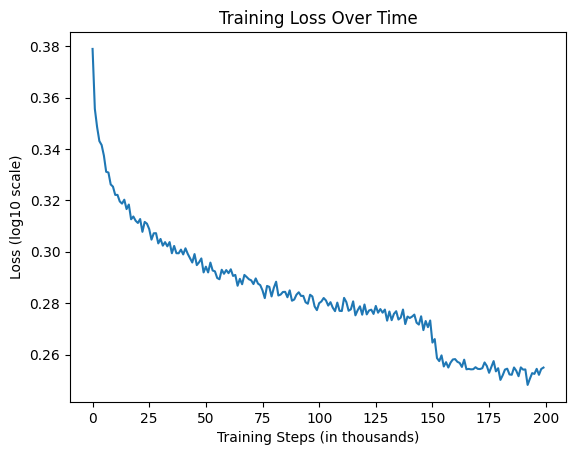

In [ ]:
# Plot training loss over time
# The loss is averaged over 1000-step windows to smooth out noise and show the overall trend
# This helps visualize how the model's performance improves during training
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.xlabel('Training Steps (in thousands)')
plt.ylabel('Loss (log10 scale)')
plt.title('Training Loss Over Time')
plt.show()

In [ ]:
# Switch all layers to evaluation mode
# This disables batch normalization's use of batch statistics
# and uses running statistics instead (important for consistent evaluation)
for layer in model.layers:
    if hasattr(layer, 'training'):
        layer.training = False

In [ ]:
@torch.no_grad()  # Disable gradient computation for evaluation (saves memory and computation)
def split_loss(split):
    """
    Compute and return the cross-entropy loss on a dataset split.

    This function evaluates the model on a specified dataset split (train/val/test)
    without computing gradients, which is appropriate for evaluation.

    Args:
        split (str): Dataset split to evaluate on. Must be one of:
            - 'train': Training set
            - 'val': Validation set
            - 'test': Test set

    Returns:
        float: Cross-entropy loss on the specified split
    """
    # Select the appropriate dataset split
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    # Forward pass: compute logits for all examples in the split
    logits = model(x.to(device))

    # Compute cross-entropy loss
    loss = F.cross_entropy(logits, y.to(device))

    # Print and return the loss
    print(f"{split} loss: {loss.item():.4f}")
    return loss.item()


# Evaluate on training and validation sets
split_loss('train')
split_loss('val')

train loss: 1.7682
val loss: 1.9919


1.9918807744979858

In [ ]:
# Sample new names from the trained model
# The model generates names character by character using autoregressive sampling

for _ in range(20):
    out = []  # List to store generated character indices
    # Initialize context with padding tokens (0 = '.' token)
    context = [0] * block_size

    # Generate characters until we sample the end token
    while True:
        # Forward pass: get logits for next character prediction
        logits = model(torch.tensor([context]).to(device))

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # Sample a character index from the probability distribution
        # This introduces randomness - the model doesn't always pick the most likely character
        ix = torch.multinomial(probs, num_samples=1).item()

        # Update context window: remove first character, add newly sampled character
        context = context[1:] + [ix]

        # Store the sampled character
        out.append(ix)

        # Stop generation if we sampled the end-of-word token ('.')
        if ix == 0:
            break

    # Convert character indices to string and print
    generated_name = ''.join(itos[i] for i in out)
    print(generated_name)

necha.
almitha.
haymone.
trinia.
cahum.
henria.
anpatalea.
destino.
kamryn.
annabeth.
zameriann.
mikklaz.
anetta.
tyrie.
ricki.
raylin.
aliena.
kayce.
edniste.
joram.
